<a href="https://colab.research.google.com/github/HyeonGilHwang/K-Digital-Training/blob/main/NLP_9%EC%9D%BC%EC%B0%A8_%EC%8B%A4%EC%8A%B5%ED%95%98%EA%B8%B0(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transformer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

(1, 50, 128)


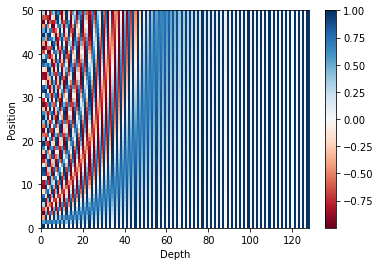

In [3]:
# 50x 128크기를 가지는 포지셔널인코딩 행렬을 시각화해서 어떤 형태를 가지는지 봅시다.
# 입력 문장의 단어가 50, 각 단어가 128차원의 임베딩 벡터를 가질 때 사용할 수 있는 행렬

sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap="RdBu")
plt.xlabel('Depth')
plt.xlim((0,128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### 어텐션

![](https://wikidocs.net/images/page/31379/attention.PNG)

- 인코더 셀프 어텐션 : Query = Key = value
- 디코더 마스크드 셀프 어텐션 : Query = Key = value
- 디코더의 인코더-디코더 어텐션 : Query (디코더 벡터)  
key = value (인코더 벡터)

![](https://wikidocs.net/images/page/31379/transformer_attention_overview.PNG)

## 인코더

![](https://wikidocs.net/images/page/31379/transformer9_final_ver.PNG)

- Query(쿼리)에 대해서 모든 키(Key)의 유사도

![](https://wikidocs.net/images/page/22893/%EC%BF%BC%EB%A6%AC.PNG)

seq2seq에서 Q,K,V
- Query: t시점의 디코더 셀에서의 은닉상태
- Key: 모든 시점의 인코더 셀의 은닉상태
- values: 모든 시점의 인코더 셀의 은닉상태

transformer에서 Q, K, V
- Query : 입력 문장의 모든 단어 벡터들
- Key : 입력 문장의 모든 단어 벡터들
- Value : 입력 문장의 모든 단어 벡터들

![](https://wikidocs.net/images/page/31379/transformer10.png)

## Q, K, V 벡터 얻기

![](https://wikidocs.net/images/page/31379/transformer11.PNG)

- $d_{model}$ = 512
- $num_heads$ = 8
- 512/8 = 64

### 스케일드 닷 프로덕트 어텐션

![](https://wikidocs.net/images/page/31379/transformer13.PNG)

![](https://wikidocs.net/images/page/31379/transformer14_final.PNG)

### 스케일드 닷- 프로덕트 어텐션 구현하기

In [4]:
def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding mask : (batch_size, 1,1, key의 문장 길이)

  # Q와 K의 곱
  matmul_qk = tf.matmul(query, key, transpose_b = True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # atttention weight : (batch_size, num_heads, query의 문장 길이,key의 문장 길이)
  attention_weight = tf.nn.softmax(logits, axis = -1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weight, value)

  return output, attention_weight

In [5]:
# scaled_dot_product_attention 함수가 정상적으로 작동하는지 테스트!
import numpy as np
import tensorflow as tf
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype = tf.float32) # (4, 3)
temp_v = tf.constant([[   1,0],
                     [  10,0],
                     [ 100,0],
                     [1000,6]], dtype =tf.float32) # (4, 2)
temp_q = tf.constant([[0, 10, 0]], dtype = tf.float32) # (1, 3)

In [6]:
# 함수를 실행
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 낭려) 
print(temp_out)# 어텐션 값

# 두번쨰와 같다고 해서 q가 k가 일치 그래서 v에서 2번째 출력

tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [7]:
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype = tf.float32) # (4, 3)
temp_v = tf.constant([[   1,0],
                     [  10,0],
                     [ 100,0],
                     [1000,6]], dtype =tf.float32) # (4, 2)
temp_q = tf.constant([[0, 0, 10]], dtype = tf.float32) # (1, 3)

In [8]:
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 3,4번쨰가 일치하네
print(temp_out)
# 550은 100 * 0.5 + 1000*0.5

tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
tf.Tensor([[550.   3.]], shape=(1, 2), dtype=float32)


In [9]:
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype = tf.float32) # (4, 3)
temp_v = tf.constant([[   1,0],
                     [  10,0],
                     [ 100,0],
                     [1000,6]], dtype =tf.float32) # (4, 2)
# 여러개 쿼리 사용
temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10,10, 0]], dtype = tf.float32) # (1, 3)

In [10]:
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn)
print(temp_out)
# temp_q가 3개니깐 각각의 유사도를 계산해서 나옴 

tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[550.    3. ]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## 멀티 헤드 어텐션

![](https://wikidocs.net/images/page/31379/transformer17.PNG)

병령 어텐션의 효과는?  
머리가 여러개이기 때문에, 여러 시점에서 상대방을 볼 수 있다.


1. $W_Q, W_k, W_v$에 해당하는 $d_{model} $크기의 밀집층(Dense layer)을 지남
2. 지정된 헤드 수 (num_heads)만큼 나눈다.
3. 스케일드 닷 프로덕트 어텐션
4. 나눠졌던 헤드들을 연결한다.
5. W_O에 해당하는 밀집층을 지나게 된다.

In [11]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, name = "multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name = name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model 을 num_heads로 나눈 값
    # 논문 기준 64
    self.depth = d_model//self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units = d_model)
    self.key_dense = tf.keras.layers.Dense(units = d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    #WQ에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

    #num_heads 개수만큼 q,k,v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape = (batch_size, -1, self.num_heads, self.depth)
    )
    return tf.transpos(inputs, perm = [0,2,1,3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inpputs['key'], inputs['value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. Wq, Wk, Wv에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)

    # 참고 ** 인코더 (k, v) - 디코더(q) 어텐션에서는 query길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문잘 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)

    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _=scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm = [0,2,1,3])

    # 4. 헤드 연결
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_dot_product_attention, (batch_size, -1, self.d_model))

    # 5. wo에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

## 패딩 마스크(Padding Mask)

![](https://wikidocs.net/images/page/31379/pad_masking11.PNG)


mask 에 작은 음수값을 -1e9(작은 음수값) 제어하기 위한 연산


![](https://wikidocs.net/images/page/31379/pad_masking2.PNG)

![](https://wikidocs.net/images/page/31379/softmax.PNG)

In [12]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0 ), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [13]:
# 임의의 정수 시퀀스를 넣고 변화를 보자
print(create_padding_mask(tf.constant([[1, 21, 777, 0, 0]])))
# 정수 시퀀스에서 0인 경우에는 1로 변환하고, 그렇지 않은 경우에는 0으로 변환하는 함수입니다.

tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)


## 포지션-와이드 피드 포워드 신경망

$$FFNN(x) = MAX(0,xW_1 + B_1 ) W_2 + b_2$$

위 식을 그림으로 표현하면 

![](https://wikidocs.net/images/page/31379/positionwiseffnn.PNG)

'''
outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)

### 잔차 연결과 층 정규화(Layer Normalization)

잔차 연결 (Residual connection)  
H(x) = x + F(x)

![](https://wikidocs.net/images/page/31379/transformer22.PNG)

H(x) = x + Sublayer(x)  
LN = LayerNorm(x + Sublayer(x))

### 인코더 구현하기

In [23]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1,1,None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 /셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6(attention + outputs))

  return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 인코더 쌓기

In [15]:
def encoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 패딩마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name = "padding_mask")

  #포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코딩를 num_layer개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name
  )

### 디코더의 첫번째 서브층 : self어텐션과 룩-헤드 마스크

![](https://wikidocs.net/images/page/31379/decoder.PNG)

![](https://wikidocs.net/images/page/31379/%EB%A3%A9%EC%96%B4%ED%97%A4%EB%93%9C%EB%A7%88%EC%8A%A4%ED%81%AC.PNG)

- 인코더에 있는 self 어텐션 : 패딩마스크 전달
- 디코더와 첫번쨰 서브층인 masked self attention : 룩-어헤드 마스크 전달 
- 디코더의 두번쨰 서브층인 인코더-디코더 어텐션:패딩마스크전달

In [16]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 mask하는 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x) #패딩 마스크 포함
  return tf.maximum(look_ahead_mask, padding_mask)

In [17]:
print(create_look_ahead_mask(tf.constant([[1,2,0,4,5]]))) # 3번쨰 0인데 모두 1로 마스킹된것을 확인

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### 디코더의 두번쨰 서브층 : 인코더-디코더 어텐션

다시한번 서브층에서 Q, K, V관계를 정리하자
- 인코더의 첫번째 서브층: Query = Key = Value
- 디코더의 첫번째 서브층: Query = Key = Value
- 디코더의 두번쨰 서브층: Query(디코더행렬) // key = value(인코더행렬)

### 디코더 구현하기

In [18]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outpus")

  # 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.Input(
      shape = (1, None, None), name="look_ahead_mask"
  )

  # 패딩마스크 (두번째 서브층)
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query':inputs, 'key':inputs, 'value':inputs, # Q= K = V
          'mask' : look_ahead_mask
      })
  
  # 잔차 연결과 층 정규화
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1+inputs)
  
  # 멀티 헤드 어텐션 (두번째 서브층/ 디코더-인코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query':attention1, 'key' : enc_outputs, 'value': enc_outputs, # Q=K=V
          'mask' : padding_mask # 패딩 마스크
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2+attention1)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs+ attention2)
  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs = outputs,
      name= name
  )

### 디코더 쌓기

In [19]:
def decoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs =tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  #디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩마스크(두번째 서브층) 둘 다 사용
  look_ahead_mask = tf.keras.Input(
      shape = (1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  #포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layer개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
                            dropout=dropout, name='decoder_layer_{}'.format(i),
                            )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
                    
  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name= name
  )

In [20]:
def transformer(vocab_size, num_layers, dff, d_model, num_heads, dropout, name="transformer"):
  #인코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  #디코더의 입력
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  #인코더의 패딩 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
  
  #디코더의 룩어헤더 마스크 (첫번째 서브층)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  
  # 디코더의 패딩 마스크 (두번째 서브층)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name= 'dec_padding_mask'
  )(inputs)

  # 인코더의 출력은 enc_outputs 디코더로 전달
  enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) #인코더의 입력은 입력문장과 패딩마스크

  # 디코더의 출력은 dec_outputs 출력층으로 전달
  dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
                        d_model=d_model, num_heads=num_heads, dropout=dropout,
                        )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 단어 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)
  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name= name)

### 트랜스포머 하이퍼파라미터 정하기

In [ ]:
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.3,
    name='small_transformer'
)

tf.keras.utils.plot_model(
    small_transformer, to_file='small_transformer.png', show_shapes=True
)
## Error가 났지만 왜 중요한지 모르겠다고 강사님이 말하심

### 손실함수 정의하기

In [25]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH -1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits = True, reduction='none')(y_true, y_pred)
  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)
  return tf.reduce_mean(loss)

$$ lr = d_{model}^{-0.5} \times  min(stepnum^{-0.5}, stepnum \times warmupsteps^{-1.5})$$

In [26]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps
  
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model)* tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

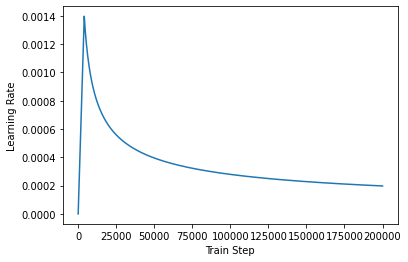

In [27]:
sample_learning_rate = CustomSchedule(d_model = 128)

plt.plot(sample_learning_rate(tf.range(200000, dtype = tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")